# IMPORTING LIBRARIES

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import *
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from transformers import BertModel, BertTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

# DATASET

In [2]:
data = load_dataset("rotten_tomatoes")
data

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to C:/Users/Prash/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

## Training set

In [3]:
train_ds = data['train']
train_ds[:5]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .',
  'effective but too-tepid biopic',
  'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .',
  "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one ."],
 'label': [1, 1, 1, 1, 1]}

In [4]:
df = pd.DataFrame(train_ds)
df

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


### Visualizing Training set

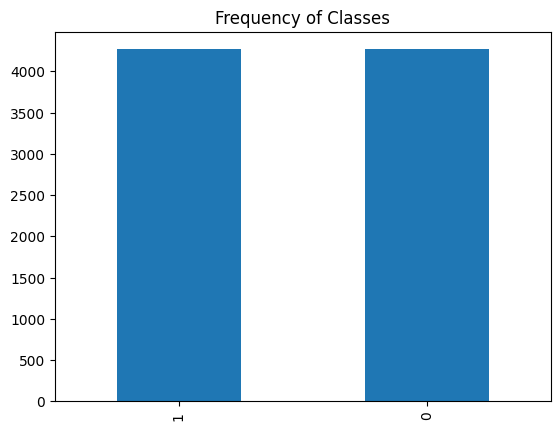

In [6]:
df['label'].value_counts(ascending=False).plot.bar()
plt.title("Frequency of Classes")
plt.show()

# DATA PREPROCESSING

## Tokenization

In [7]:
model_ckpt = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

data_encoded = data.map(tokenize, batched=True, batch_size=None)
data_encoded['train'].column_names

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

## Feature Extraction

In [9]:
def extract_hidden_states(batch):
    inputs = {k:v for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [10]:
data_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])
data_hidden = data_encoded.map(extract_hidden_states, batched=True)
data_hidden["train"].column_names

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

['text',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [11]:
x_train = np.array(data_hidden['train']['hidden_state'])
x_test = np.array(data_hidden['test']['hidden_state'])
y_train = np.array(data_hidden['train']['label'])
y_test = np.array(data_hidden['test']['label'])
y_valid = np.array(data_hidden['validation']['label'])
x_valid = np.array(data_hidden['validation']['hidden_state'])

x_train.shape, x_valid.shape, x_test.shape

((8530, 768), (1066, 768), (1066, 768))

# TRAINING MODELS

In [13]:
nb = GaussianNB()
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=3000)
svm = SVC()
tree = DecisionTreeClassifier()
mnb = MultinomialNB()

In [14]:
scaler = MinMaxScaler()
m = scaler.fit_transform(x_train)
n = scaler.transform(x_valid)

mnb.fit(m, y_train)
nb.fit(x_train, y_train)
knn.fit(x_train, y_train)
lr.fit(x_train, y_train)
svm.fit(x_train, y_train)
tree.fit(x_train, y_train)

print(f"Multinomial Naive Bayes Accuracy: {mnb.score(n,y_valid)}")
print(f"Gaussian Naive Bayes Accuracy: {nb.score(x_valid,y_valid)}")
print(f"KNN Accuracy: {knn.score(x_valid,y_valid)}")
print(f"Logistic Regression Accuracy: {lr.score(x_valid,y_valid)}")
print(f"SVC Accuracy: {svm.score(x_valid,y_valid)}")
print(f"Decision Tree Accuracy: {tree.score(x_valid,y_valid)}")

Multinomial Naive Bayes Accuracy: 0.7607879924953096
Gaussian Naive Bayes Accuracy: 0.7607879924953096
KNN Accuracy: 0.7664165103189493
Logistic Regression Accuracy: 0.8236397748592871
SVC Accuracy: 0.8330206378986866
Decision Tree Accuracy: 0.6754221388367729


In [38]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print(f"Random Forest Accuracy: {rf.score(x_valid, y_valid)}")

Random Forest Accuracy: 0.7954971857410882


In [39]:
gx = XGBClassifier()
gx.fit(x_train, y_train)
gx.score(x_valid, y_valid)

0.8151969981238274

In [34]:
logreg = LogisticRegression(C=0.1, l1_ratio=0.2, penalty='elasticnet', solver='saga', max_iter=1000)
logreg.fit(x_train, y_train)
print(f"Best Performance of Logistic Regression: {logreg.score(x_valid, y_valid)}")

Best Performance of Logistic Regression: 0.8414634146341463


In [17]:
svm = SVC(C=100, decision_function_shape='ovo', gamma=0.035)

svm.fit(x_train, y_train)
print(f"Best Performance of SVC: {svm.score(x_valid, y_valid)}")

Best Performance of SVC: 0.8330206378986866


In [18]:
models = [
    ('xgb', gx),
    ('svc', svm),
    ('logreg', logreg)
]
stacked_model = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

stacked_model.fit(x_train, y_train)

stacked_model.score(x_valid, y_valid)

0.8386491557223265

In [19]:
stacked_model2 = StackingClassifier(estimators=models, final_estimator=SVC())

stacked_model2.fit(x_train, y_train)

stacked_model2.score(x_valid, y_valid)

0.8424015009380863

# VISUALIZING PERFORMANCE

In [44]:
def performance(model, x_test, y_test):
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    print("                 Model Performance")
    print(report)
    print(f"Accuracy = {round(accuracy*100, 2)}%")
    matrix = confusion_matrix(y_test, preds)
    matrix_disp = ConfusionMatrixDisplay(matrix)
    matrix_disp.plot(cmap='Blues')
    plt.show()

                 Model Performance
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       533
           1       0.84      0.80      0.82       533

    accuracy                           0.82      1066
   macro avg       0.82      0.82      0.82      1066
weighted avg       0.82      0.82      0.82      1066

Accuracy = 82.08%


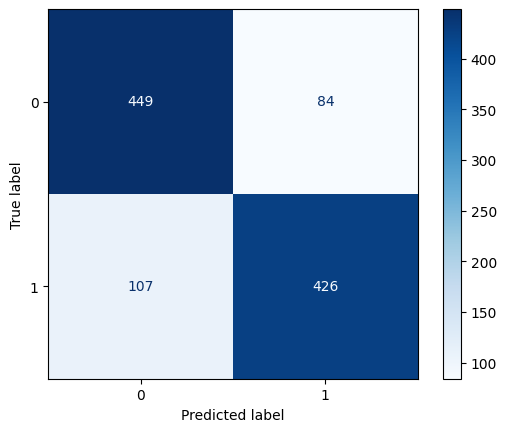

In [50]:
performance(stacked_model, x_test, y_test)

                 Model Performance
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       533
           1       0.85      0.78      0.82       533

    accuracy                           0.82      1066
   macro avg       0.83      0.82      0.82      1066
weighted avg       0.83      0.82      0.82      1066

Accuracy = 82.46%


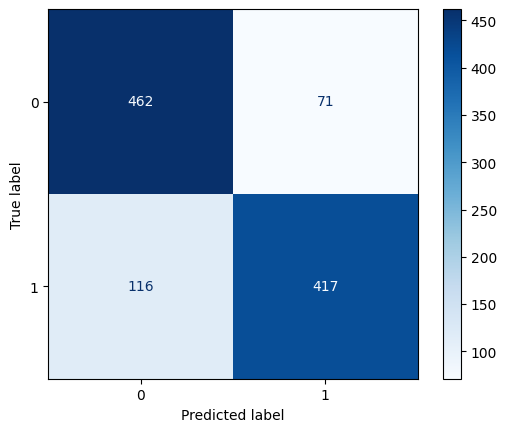

In [45]:
performance(stacked_model2, x_test, y_test)

                 Model Performance
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       533
           1       0.82      0.80      0.81       533

    accuracy                           0.81      1066
   macro avg       0.81      0.81      0.81      1066
weighted avg       0.81      0.81      0.81      1066

Accuracy = 81.14%


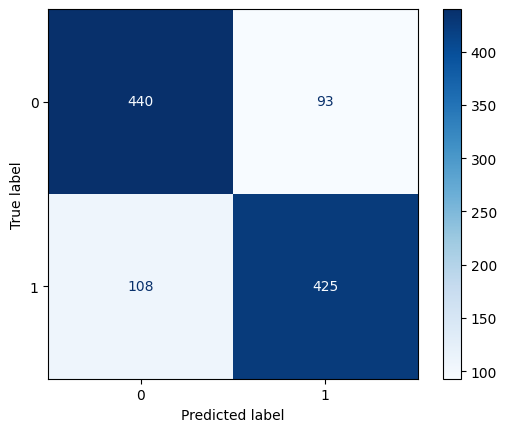

In [46]:
performance(logreg, x_test, y_test)

                 Model Performance
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       533
           1       0.83      0.80      0.81       533

    accuracy                           0.82      1066
   macro avg       0.82      0.82      0.82      1066
weighted avg       0.82      0.82      0.82      1066

Accuracy = 81.52%


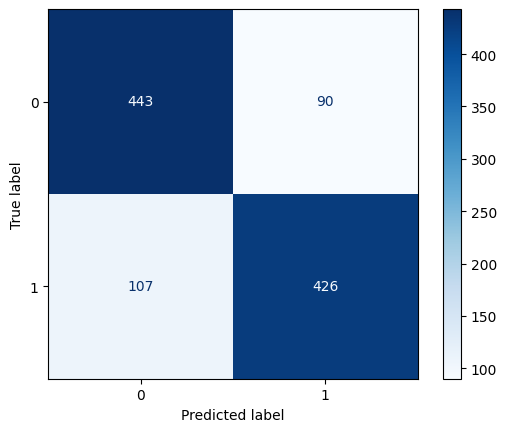

In [47]:
performance(svm, x_test, y_test)

                 Model Performance
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       533
           1       0.82      0.78      0.80       533

    accuracy                           0.80      1066
   macro avg       0.81      0.80      0.80      1066
weighted avg       0.81      0.80      0.80      1066

Accuracy = 80.49%


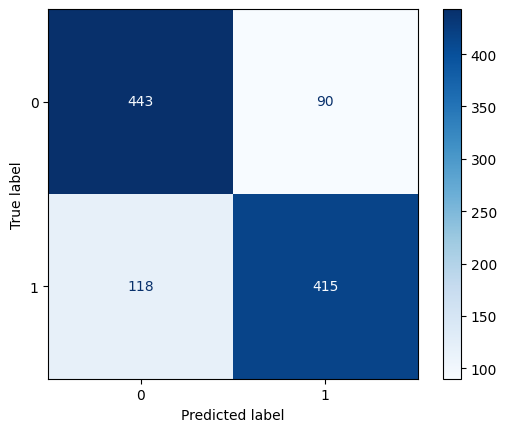

In [48]:
performance(gx, x_test, y_test)

                 Model Performance
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       533
           1       0.81      0.73      0.77       533

    accuracy                           0.78      1066
   macro avg       0.78      0.78      0.78      1066
weighted avg       0.78      0.78      0.78      1066

Accuracy = 77.95%


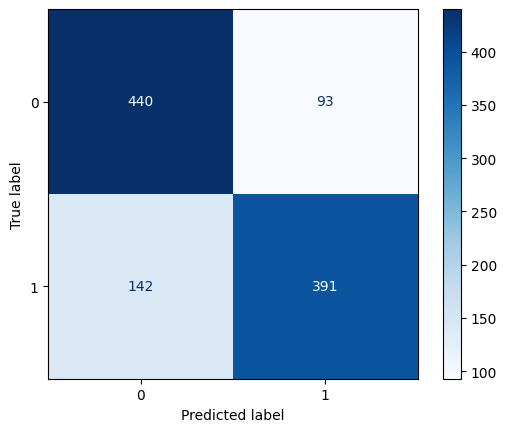

In [49]:
performance(rf, x_test, y_test)